# Which Economic Tasks are Performed with AI? Evidence from Millions of Claude Conversations

_Handa et al., 2025_

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import numpy as np

palette = sns.color_palette("colorblind")

### Create O*NET / SOC Merged Dataframe

In [2]:
def merge_onet_soc_data() -> pd.DataFrame:
    """
    Merges O*NET task statements with SOC (Standard Occupational Classification) data
    based on major group codes.
    
    Args:
        onet_path (str): Path to the O*NET task statements CSV file
        soc_path (str): Path to the SOC structure CSV file
    
    Returns:
        pd.DataFrame: Merged DataFrame containing O*NET data with SOC major group titles
    """

    # Read and process O*NET data
    onet_df = pd.read_csv("onet_task_statements.csv")
    onet_df["soc_major_group"] = onet_df["O*NET-SOC Code"].str[:2]
    
    # Read and process SOC data
    soc_df = pd.read_csv("SOC_Structure.csv")
    soc_df = soc_df.dropna(subset=['Major Group'])
    soc_df["soc_major_group"] = soc_df["Major Group"].str[:2]
    
    # Merge datasets
    merged_df = onet_df.merge(
        soc_df[['soc_major_group', 'SOC or O*NET-SOC 2019 Title']],
        on='soc_major_group',
        how='left'
    )

    return merged_df

In [3]:
task_occupations_df = merge_onet_soc_data()

In [4]:
task_occupations_df["Title"].nunique()

974

In [5]:
# Update cluster mappings to include data from the merged_df
task_occupations_df["task_normalized"] = task_occupations_df["Task"].str.lower().str.strip()
# Some tasks are included multiple times, so we need to count the number of occurrences per task
task_occupations_df["n_occurrences"] = task_occupations_df.groupby("task_normalized")["Title"].transform("nunique")

task_occupations_df

,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,soc_major_group,SOC or O*NET-SOC 2019 Title,task_normalized,n_occurrences
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,87.0,07/2014,Incumbent,11,Management Occupations,direct or coordinate an organization's financi...,1
1,11-1011.00,Chief Executives,8831,Appoint department heads or managers and assig...,Core,87.0,07/2014,Incumbent,11,Management Occupations,appoint department heads or managers and assig...,1
2,11-1011.00,Chief Executives,8825,Analyze operations to evaluate performance of ...,Core,87.0,07/2014,Incumbent,11,Management Occupations,analyze operations to evaluate performance of ...,1
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,87.0,07/2014,Incumbent,11,Management Occupations,"direct, plan, or implement policies, objective...",1
4,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,87.0,07/2014,Incumbent,11,Management Occupations,"prepare budgets for approval, including those ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...
19525,53-7121.00,"Tank Car, Truck, and Ship Loaders",12806,"Test vessels for leaks, damage, and defects, a...",Supplemental,66.0,12/2006,Incumbent,53,Transportation and Material Moving Occupations,"test vessels for leaks, damage, and defects, a...",1
19526,53-7121.00,"Tank Car, Truck, and Ship Loaders",12807,Unload cars containing liquids by connecting h...,Supplemental,66.0,12/2006,Incumbent,53,Transportation and Material Moving Occupations,unload cars containing liquids by connecting h...,1
19527,53-7121.00,"Tank Car, Truck, and Ship Loaders",12808,Copy and attach load specifications to loaded ...,Supplemental,64.0,12/2006,Incumbent,53,Transportation and Material Moving Occupations,copy and attach load specifications to loaded ...,1
19528,53-7121.00,"Tank Car, Truck, and Ship Loaders",12809,Start pumps and adjust valves or cables to reg...,Supplemental,67.0,12/2006,Incumbent,53,Transportation and Material Moving Occupations,start pumps and adjust valves or cables to reg...,1


### Load Task Mappings and Join

In [6]:
task_mappings_df = pd.read_csv("onet_task_mappings.csv")

In [7]:
grouped_with_occupations = task_mappings_df.merge(
    task_occupations_df,
    left_on="task_name",
    right_on="task_normalized",
    how="left"
)

grouped_with_occupations["pct_occ_scaled"] = 100 * (grouped_with_occupations["pct"] / grouped_with_occupations["n_occurrences"]) / (grouped_with_occupations["pct"] / grouped_with_occupations["n_occurrences"]).sum()
grouped_with_occupations["pct_occ_scaled"].sum()

np.float64(100.0)

In [8]:
grouped_with_occupations

,task_name,pct,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,soc_major_group,SOC or O*NET-SOC 2019 Title,task_normalized,n_occurrences,pct_occ_scaled
0,act as advisers to student organizations.,0.006775,25-1011.00,"Business Teachers, Postsecondary",5682.0,Act as advisers to student organizations.,Core,95.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,0.000200
1,act as advisers to student organizations.,0.006775,25-1021.00,"Computer Science Teachers, Postsecondary",5700.0,Act as advisers to student organizations.,Supplemental,58.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,0.000200
2,act as advisers to student organizations.,0.006775,25-1022.00,"Mathematical Science Teachers, Postsecondary",5726.0,Act as advisers to student organizations.,Supplemental,107.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,0.000200
3,act as advisers to student organizations.,0.006775,25-1031.00,"Architecture Teachers, Postsecondary",5751.0,Act as advisers to student organizations.,Supplemental,72.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,0.000200
4,act as advisers to student organizations.,0.006775,25-1032.00,"Engineering Teachers, Postsecondary",5774.0,Act as advisers to student organizations.,Supplemental,70.0,07/2011,Incumbent,25,Educational Instruction and Library Occupations,act as advisers to student organizations.,34.0,0.000200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,"write, design, or edit web page content, or di...",0.320908,15-1134.00,Web Developers,14696.0,"Write, design, or edit Web page content, or di...",Core,30.0,06/2008,Occupational Expert,15,Computer and Mathematical Occupations,"write, design, or edit web page content, or di...",1.0,0.322461
4241,"write, present, and publish reports that recor...",0.117393,19-3091.02,Archeologists,9155.0,"Write, present, and publish reports that recor...",Core,33.0,07/2012,Occupational Expert,19,"Life, Physical, and Social Science Occupations","write, present, and publish reports that recor...",1.0,0.117961
4242,"write, review, or execute plans for testing ne...",0.010944,15-1199.12,Document Management Specialists,16220.0,"Write, review, or execute plans for testing ne...",Core,25.0,07/2013,Occupational Expert,15,Computer and Mathematical Occupations,"write, review, or execute plans for testing ne...",1.0,0.010997
4243,"write, review, or maintain engineering documen...",0.076872,17-2141.02,Automotive Engineers,16425.0,"Write, review, or maintain engineering documen...",Core,23.0,07/2014,Occupational Expert,17,Architecture and Engineering Occupations,"write, review, or maintain engineering documen...",1.0,0.077244


### OCCUPATIONS

In [9]:
grouped_with_occupations.groupby("Title")["pct_occ_scaled"].sum()

Title
Accountants                           0.401014
Actors                                0.784222
Actuaries                             0.064806
Acupuncturists                        0.028148
Acute Care Nurses                     0.040062
                                        ...   
Wind Energy Engineers                 0.002880
Wind Energy Operations Managers       0.008903
Wind Energy Project Managers          0.014794
Word Processors and Typists           0.415677
Zoologists and Wildlife Biologists    0.039800
Name: pct_occ_scaled, Length: 756, dtype: float64

/var/folders/31/rr3vvs0x69v0hzh5y29651200000gn/T/ipykernel_18096/1992135786.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=40))


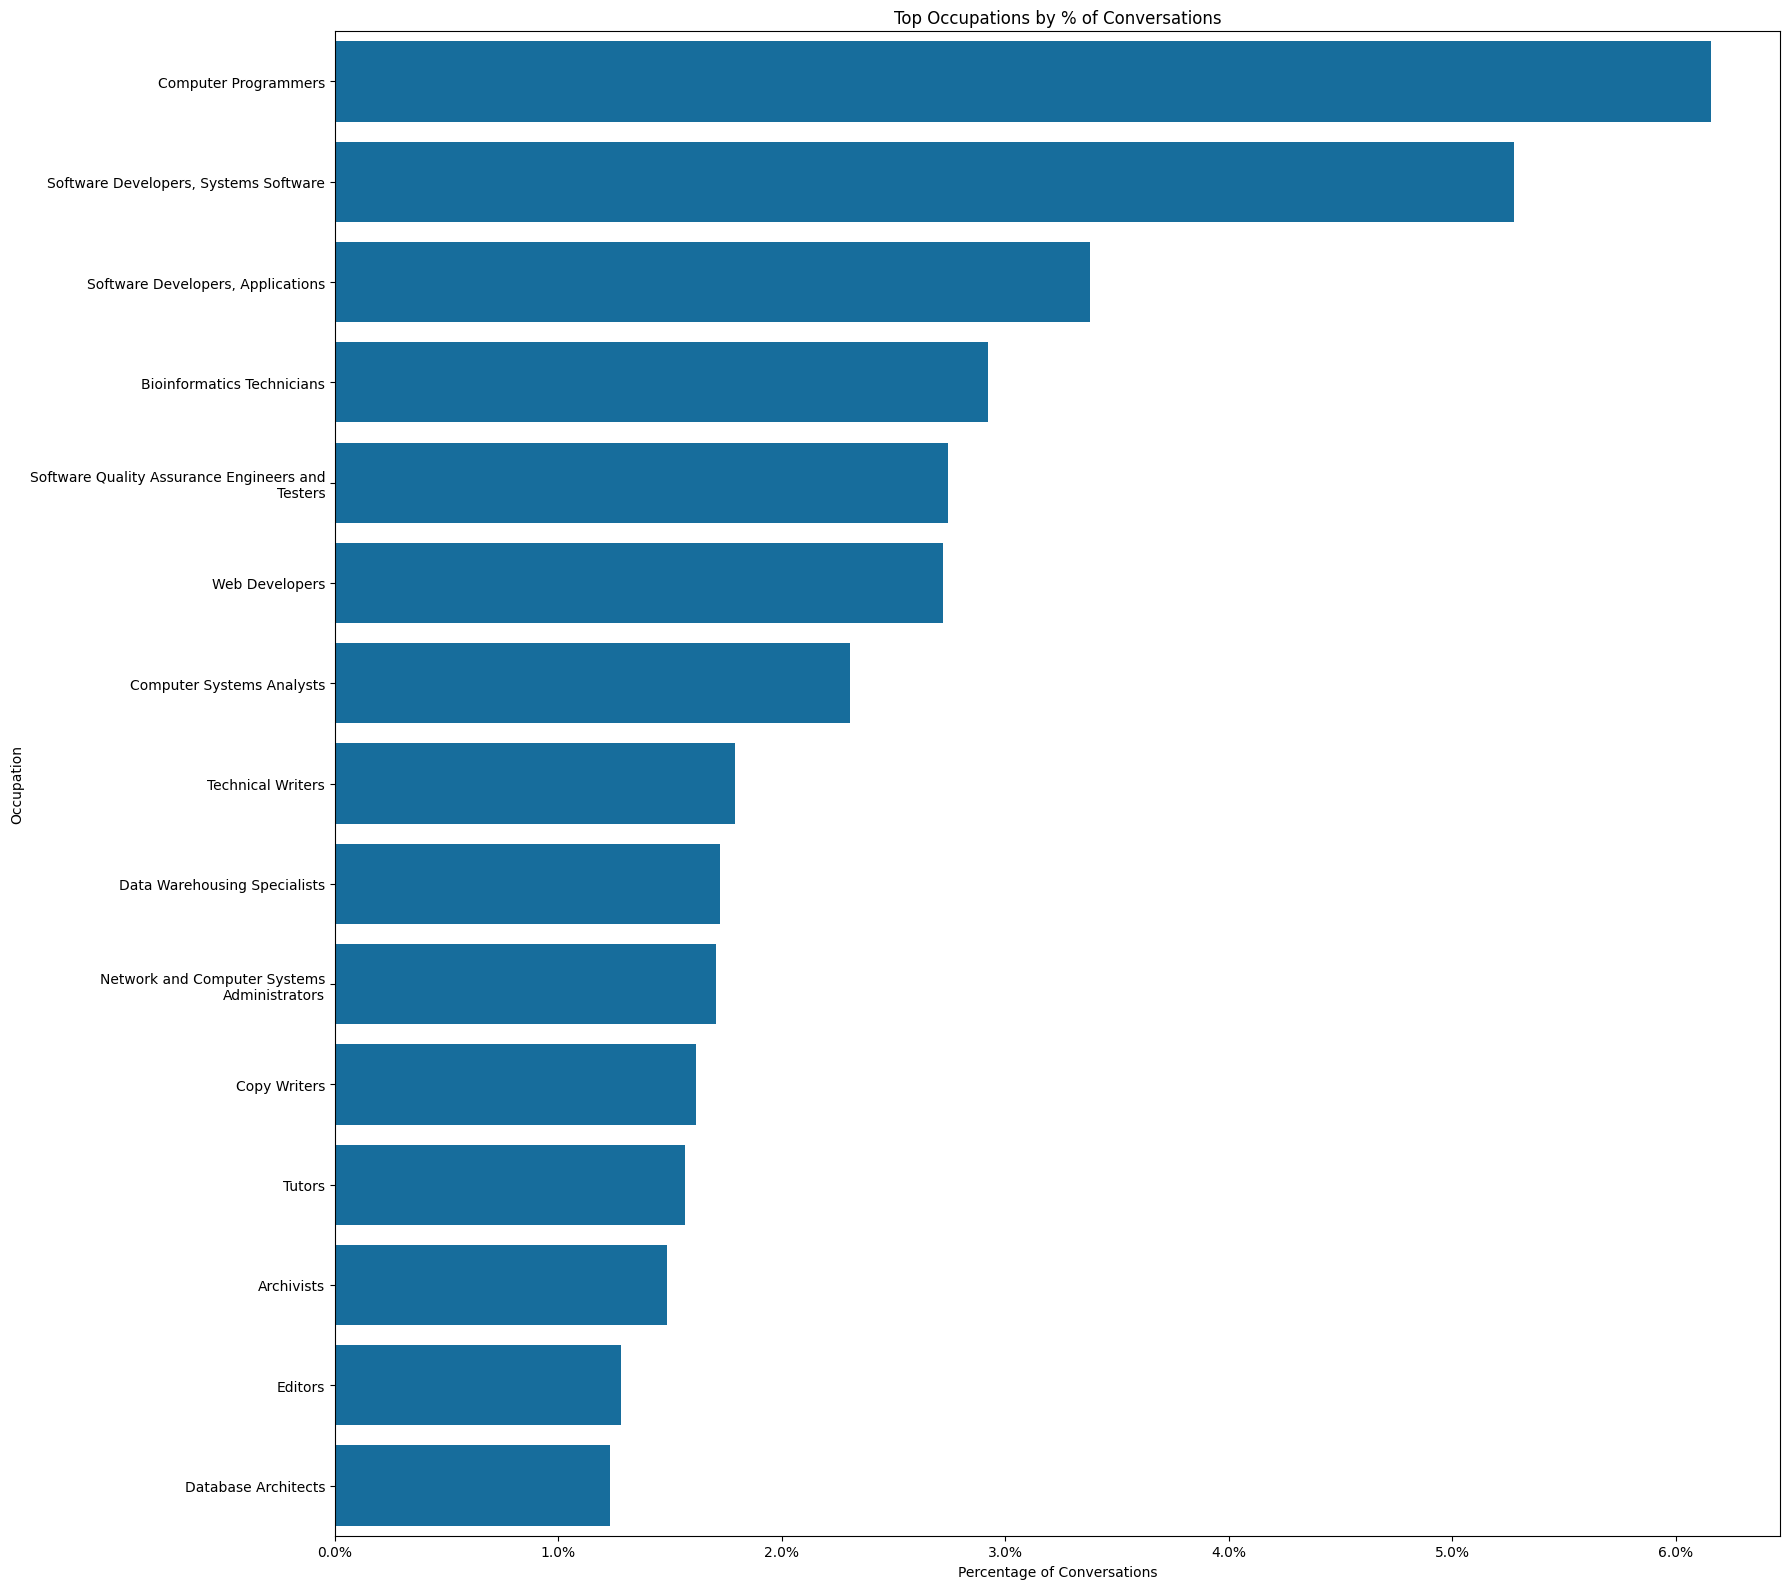

In [10]:
# Calculate percentages per group and occupation
plot_df = (grouped_with_occupations.groupby("Title")["pct_occ_scaled"]
           .sum()
           .reset_index())

# Get top occupations overall
total_occs = (plot_df.groupby("Title")["pct_occ_scaled"]
              .sum()
              .sort_values(ascending=False))
top_occs = total_occs.head(15).index

# Filter for top occupations
plot_df = plot_df[plot_df["Title"].isin(top_occs)]

# Sort occupations by overall frequency
occ_order = (plot_df.groupby("Title")["pct_occ_scaled"]
             .sum()
             .sort_values(ascending=False)
             .index)
plot_df["Title"] = pd.Categorical(plot_df["Title"], categories=occ_order, ordered=True)

# Create the plot
plt.figure(figsize=(18, 16))
sns.barplot(
    data=plot_df,
    x="pct_occ_scaled",
    y="Title",
    color=palette[0],
)

# Wrap occupation titles
ax = plt.gca()
ax.set_yticklabels(['\n'.join(wrap(label.get_text(), width=40)) 
                    for label in ax.get_yticklabels()])

# Format x-axis as percentages
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))

# Customize the plot
plt.title('Top Occupations by % of Conversations')
plt.xlabel('Percentage of Conversations')
plt.ylabel('Occupation')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

### OCCUPATIONAL CATEGORIES

/var/folders/31/rr3vvs0x69v0hzh5y29651200000gn/T/ipykernel_18096/1631959488.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['\n'.join(wrap(label.get_text().replace(" Occupations", ""), width=60))


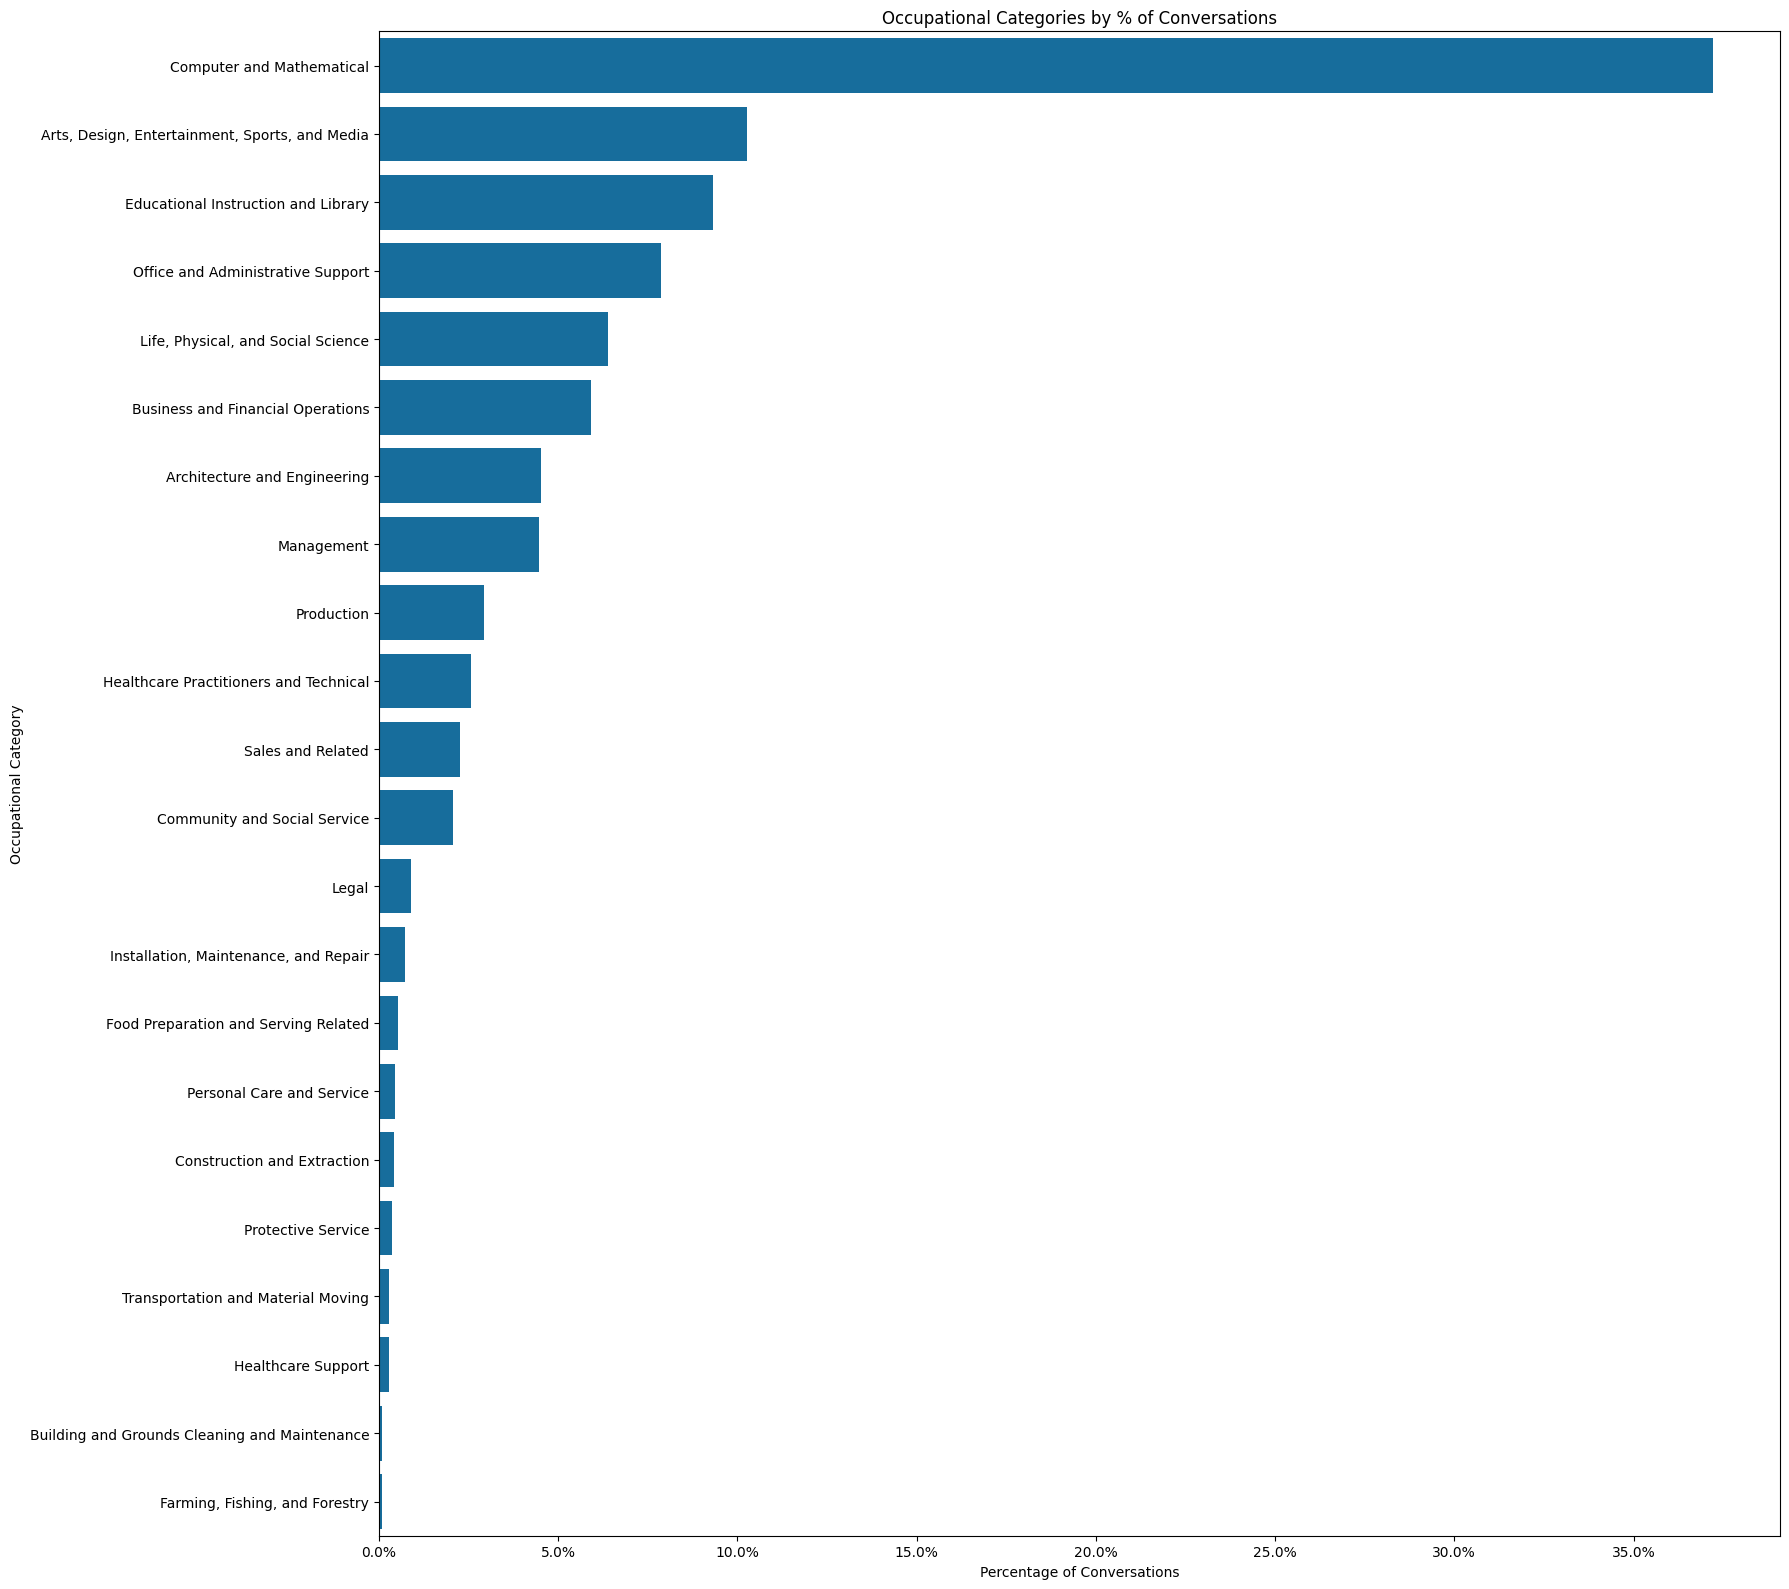

In [11]:
# Calculate percentages per group and occupational category
plot_df = (grouped_with_occupations.groupby("SOC or O*NET-SOC 2019 Title")["pct_occ_scaled"]
           .sum()
           .reset_index())

# Sort categories by group-1 frequency
cat_order = plot_df.sort_values("pct_occ_scaled", ascending=False)["SOC or O*NET-SOC 2019 Title"]
plot_df["SOC or O*NET-SOC 2019 Title"] = pd.Categorical(
    plot_df["SOC or O*NET-SOC 2019 Title"], 
    categories=cat_order, 
    ordered=True
)

# Create the plot
plt.figure(figsize=(18, 16))
sns.barplot(
    data=plot_df,
    x="pct_occ_scaled",
    y="SOC or O*NET-SOC 2019 Title",
    color=palette[0],
)

# Wrap category labels and remove " Occupations" string
ax = plt.gca()
ax.set_yticklabels(['\n'.join(wrap(label.get_text().replace(" Occupations", ""), width=60)) 
                    for label in ax.get_yticklabels()])

# Format x-axis as percentages
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))

# Customize the plot
plt.title('Occupational Categories by % of Conversations')
plt.xlabel('Percentage of Conversations')
plt.ylabel('Occupational Category')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [13]:
# Load employment data
bls_employment_df = pd.read_csv("bls_employment_may_2023.csv")

claude_employment_df = grouped_with_occupations.groupby("SOC or O*NET-SOC 2019 Title")["pct_occ_scaled"].sum().reset_index(name='claude_distribution')

employment_df = claude_employment_df.merge(bls_employment_df, 
                                     on='SOC or O*NET-SOC 2019 Title',
                                     how='left')

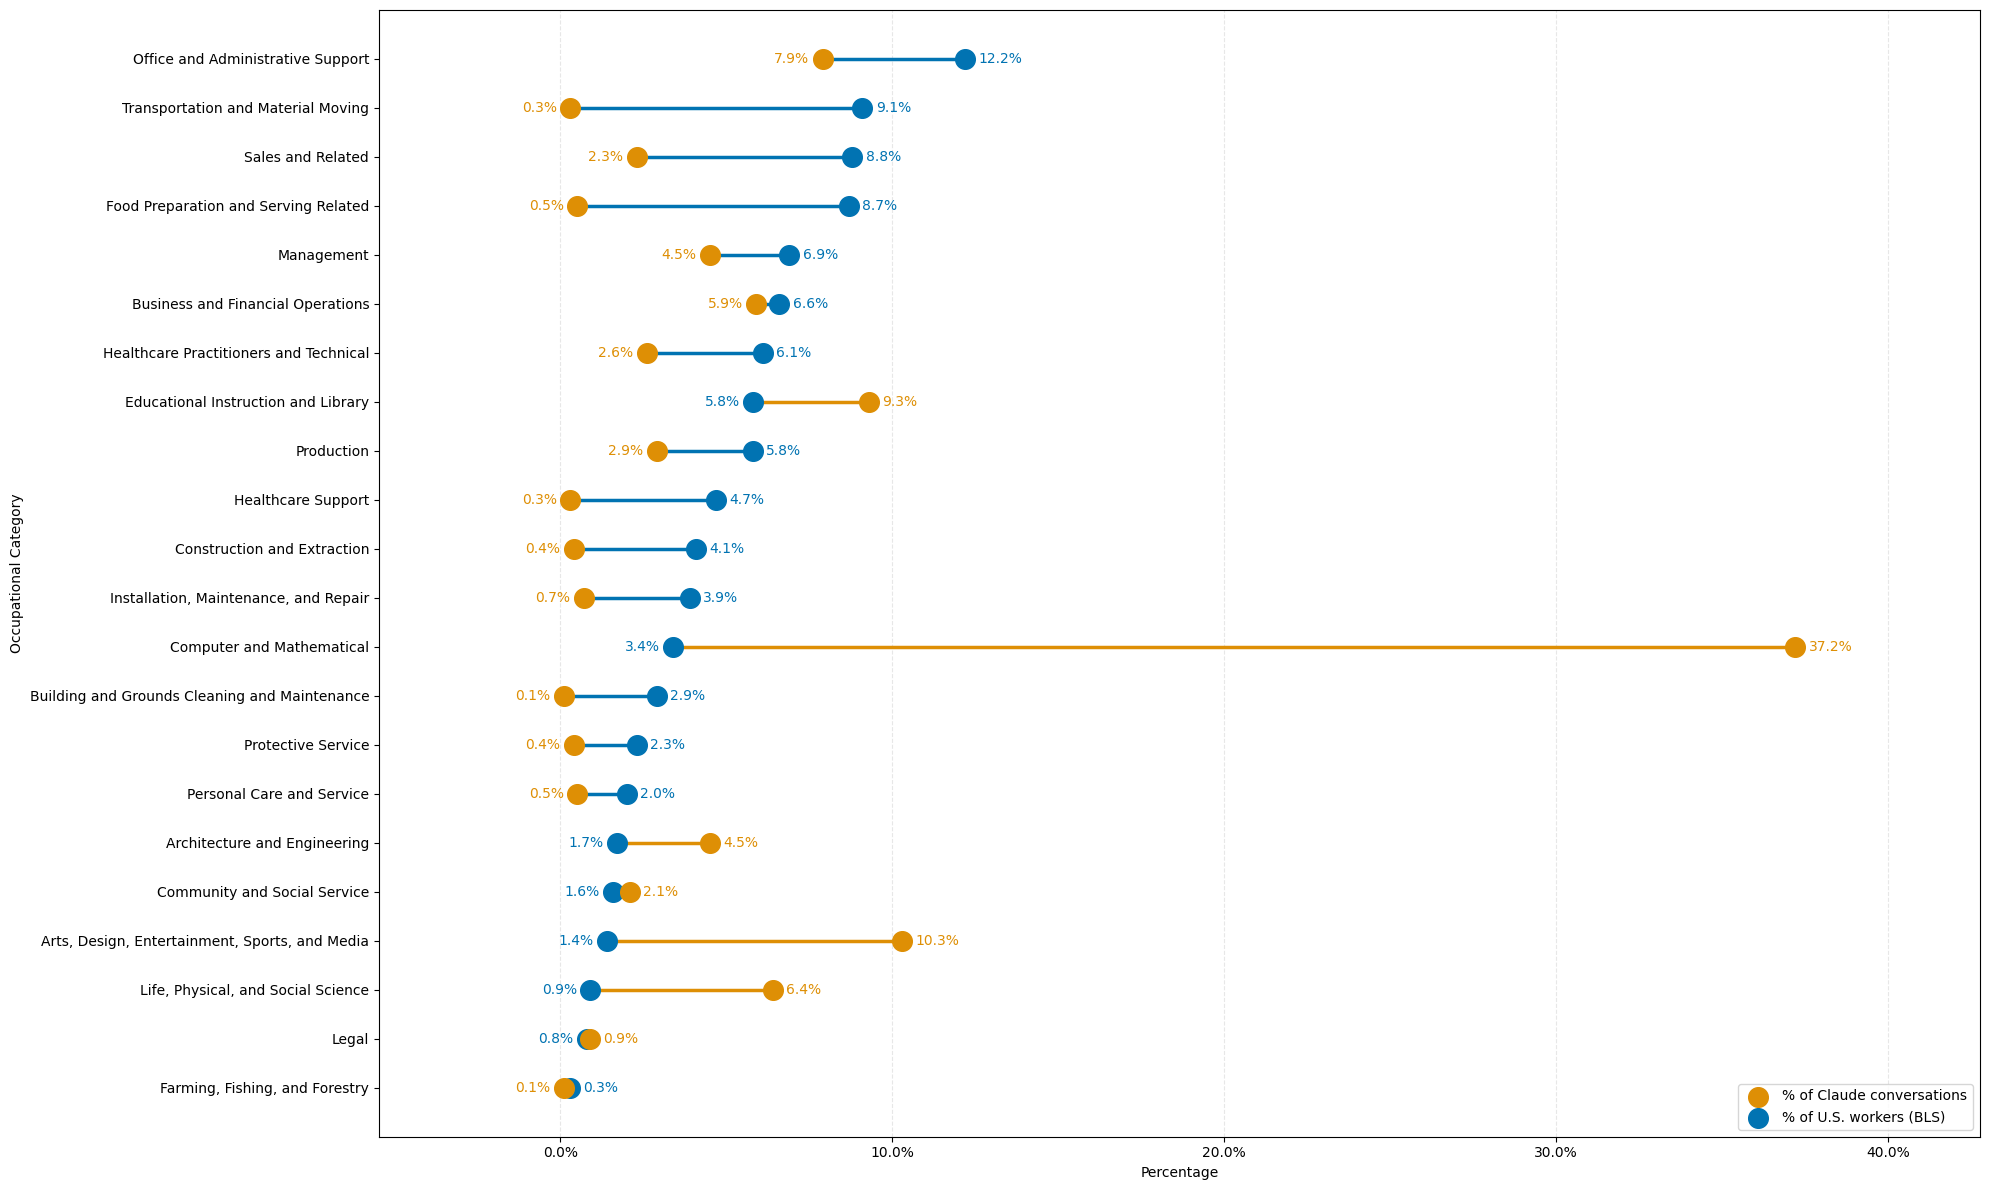

In [14]:
# Calculate percentages and setup data
plot_df = employment_df.copy()

def get_distribution(df, value_column):
   total = df[value_column].sum()
   return (df[value_column] / total * 100).round(1)

plot_df['bls_pct'] = get_distribution(plot_df, 'bls_distribution')
plot_df['claude_pct'] = get_distribution(plot_df, 'claude_distribution')
plot_df['clean_label'] = plot_df['SOC or O*NET-SOC 2019 Title'].str.replace(' Occupations', '')
plot_df['pct_difference'] = plot_df['claude_pct'] - plot_df['bls_pct']
plot_df = plot_df.sort_values('bls_pct', ascending=True)

# Create the plot
fig, ax = plt.subplots(figsize=(20, 12))

# Set colors
claude_color = palette[1] 
bls_color = palette[0] 

# Create lines and circles
y_positions = range(len(plot_df))
for i, row in enumerate(plot_df.itertuples()):
   # Determine color based on which value is larger
   line_color = claude_color if row.claude_pct > row.bls_pct else bls_color
   
   # Draw the line between bls and claude percentages
   ax.plot([row.bls_pct, row.claude_pct], [i, i], 
           color=line_color, 
           linestyle='-', 
           linewidth=2.5,
           zorder=1)
   
   # Determine label positioning
   if row.claude_pct > row.bls_pct:
       bls_ha = 'right'
       claude_ha = 'left'
       bls_offset = -0.4
       claude_offset = 0.4
   else:
       bls_ha = 'left'
       claude_ha = 'right'
       bls_offset = 0.4
       claude_offset = -0.4

   # Plot BLS percentage
   ax.scatter([row.bls_pct], [i], 
              color=bls_color,
              s=200,
              zorder=2,
              label='% of U.S. workers (BLS)' if i == 0 else "")
   ax.text(row.bls_pct + bls_offset,
           i,
           f'{row.bls_pct:.1f}%',
           ha=bls_ha,
           va='center',
           color=bls_color)
   
   # Plot Claude's percentage
   ax.scatter([row.claude_pct], [i], 
              color=claude_color,
              s=200,
              zorder=2,
              label='% of Claude conversations' if i == 0 else "")
   ax.text(row.claude_pct + claude_offset,
           i,
           f'{row.claude_pct:.1f}%',
           ha=claude_ha,
           va='center',
           color=claude_color)

# Customize the plot
ax.set_xlabel('Percentage')
ax.set_ylabel('Occupational Category')

# Add percentage formatter to x-axis
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))

# Set y-axis labels
ax.set_yticks(y_positions)
ax.set_yticklabels(plot_df['clean_label'])

# Add legend
handles, labels = ax.get_legend_handles_labels()
handles = handles[::-1]
labels = labels[::-1]
ax.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.0, 0.0))

# Adjust grid and layout
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Set axis limits with padding
max_val = max(plot_df['bls_pct'].max(), plot_df['claude_pct'].max())
min_val = min(plot_df['bls_pct'].min(), plot_df['claude_pct'].min())
padding = (max_val - min_val) * 0.15
ax.set_xlim(min_val - padding, max_val + padding)
ax.set_ylim(-1, len(plot_df))

# Adjust layout
plt.tight_layout()
plt.show()

### USAGE BY WAGE

In [15]:
# Read and process wage data
wage_df = pd.read_csv("wage_data.csv")

In [16]:
wage_df

,SOCcode,JobName,JobFamily,isBright,isGreen,JobZone,MedianSalary,JobForecast,ChanceAuto,WageGroup
0,13-2011.01,Accountants,Business and Financial Operations,True,False,4,70500.00,146000,-1.0,Accountants and Auditors
1,13-2011.00,Accountants and Auditors,Business and Financial Operations,True,False,-1,70500.00,146000,94.0,NaN
2,27-2011.00,Actors,"Arts, Design, Entertainment, Sports, and Media",False,False,2,17.54,7700,37.0,NaN
3,15-2011.00,Actuaries,Computer and Mathematical,True,False,4,102880.00,2200,21.0,NaN
4,29-1199.01,Acupuncturists,Healthcare Practitioners and Technical,True,False,5,73960.00,3400,-1.0,"Health Diagnosing and Treating Practitioners, ..."
...,...,...,...,...,...,...,...,...,...,...
1085,51-7099.00,"Woodworkers, All Other",Production,False,False,-1,31170.00,1900,-1.0,NaN
1086,51-7042.00,"Woodworking Machine Setters, Operators, and Te...",Production,False,False,2,29730.00,11100,97.0,NaN
1087,43-9022.00,Word Processors and Typists,Office and Administrative Support,False,False,2,39750.00,4100,81.0,NaN
1088,27-3043.00,Writers and Authors,"Arts, Design, Entertainment, Sports, and Media",False,False,-1,62170.00,12800,4.0,NaN


In [17]:
# Join wage and occupation data
grouped_with_occupations_and_wage = grouped_with_occupations.merge(wage_df, left_on="O*NET-SOC Code", right_on="SOCcode", how="left")
grouped_with_occupations_and_wage

,task_name,pct,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source,...,SOCcode,JobName,JobFamily,isBright,isGreen,JobZone,MedianSalary,JobForecast,ChanceAuto,WageGroup
0,act as advisers to student organizations.,0.006775,25-1011.00,"Business Teachers, Postsecondary",5682.0,Act as advisers to student organizations.,Core,95.0,07/2011,Incumbent,...,25-1011.00,"Business Teachers, Postsecondary","Education, Training, and Library",True,False,5.0,83960.0,11200.0,-1.0,NaN
1,act as advisers to student organizations.,0.006775,25-1021.00,"Computer Science Teachers, Postsecondary",5700.0,Act as advisers to student organizations.,Supplemental,58.0,07/2011,Incumbent,...,25-1021.00,"Computer Science Teachers, Postsecondary","Education, Training, and Library",False,False,5.0,82220.0,3600.0,-1.0,NaN
2,act as advisers to student organizations.,0.006775,25-1022.00,"Mathematical Science Teachers, Postsecondary",5726.0,Act as advisers to student organizations.,Supplemental,107.0,07/2011,Incumbent,...,25-1022.00,"Mathematical Science Teachers, Postsecondary","Education, Training, and Library",False,False,5.0,73230.0,5300.0,-1.0,NaN
3,act as advisers to student organizations.,0.006775,25-1031.00,"Architecture Teachers, Postsecondary",5751.0,Act as advisers to student organizations.,Supplemental,72.0,07/2011,Incumbent,...,25-1031.00,"Architecture Teachers, Postsecondary","Education, Training, and Library",True,False,5.0,86980.0,800.0,-1.0,NaN
4,act as advisers to student organizations.,0.006775,25-1032.00,"Engineering Teachers, Postsecondary",5774.0,Act as advisers to student organizations.,Supplemental,70.0,07/2011,Incumbent,...,25-1032.00,"Engineering Teachers, Postsecondary","Education, Training, and Library",True,False,5.0,101720.0,4700.0,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4240,"write, design, or edit web page content, or di...",0.320908,15-1134.00,Web Developers,14696.0,"Write, design, or edit Web page content, or di...",Core,30.0,06/2008,Occupational Expert,...,15-1134.00,Web Developers,Computer and Mathematical,True,False,3.0,69430.0,15100.0,21.0,NaN
4241,"write, present, and publish reports that recor...",0.117393,19-3091.02,Archeologists,9155.0,"Write, present, and publish reports that recor...",Core,33.0,07/2012,Occupational Expert,...,19-3091.02,Archeologists,"Life, Physical, and Social Science",True,False,5.0,62410.0,800.0,-1.0,Anthropologists and Archeologists
4242,"write, review, or execute plans for testing ne...",0.010944,15-1199.12,Document Management Specialists,16220.0,"Write, review, or execute plans for testing ne...",Core,25.0,07/2013,Occupational Expert,...,15-1199.12,Document Management Specialists,Computer and Mathematical,True,False,4.0,90270.0,35700.0,-1.0,"Computer Occupations, All Other"
4243,"write, review, or maintain engineering documen...",0.076872,17-2141.02,Automotive Engineers,16425.0,"Write, review, or maintain engineering documen...",Core,23.0,07/2014,Occupational Expert,...,17-2141.02,Automotive Engineers,Architecture and Engineering,False,True,4.0,87370.0,22900.0,-1.0,Mechanical Engineers


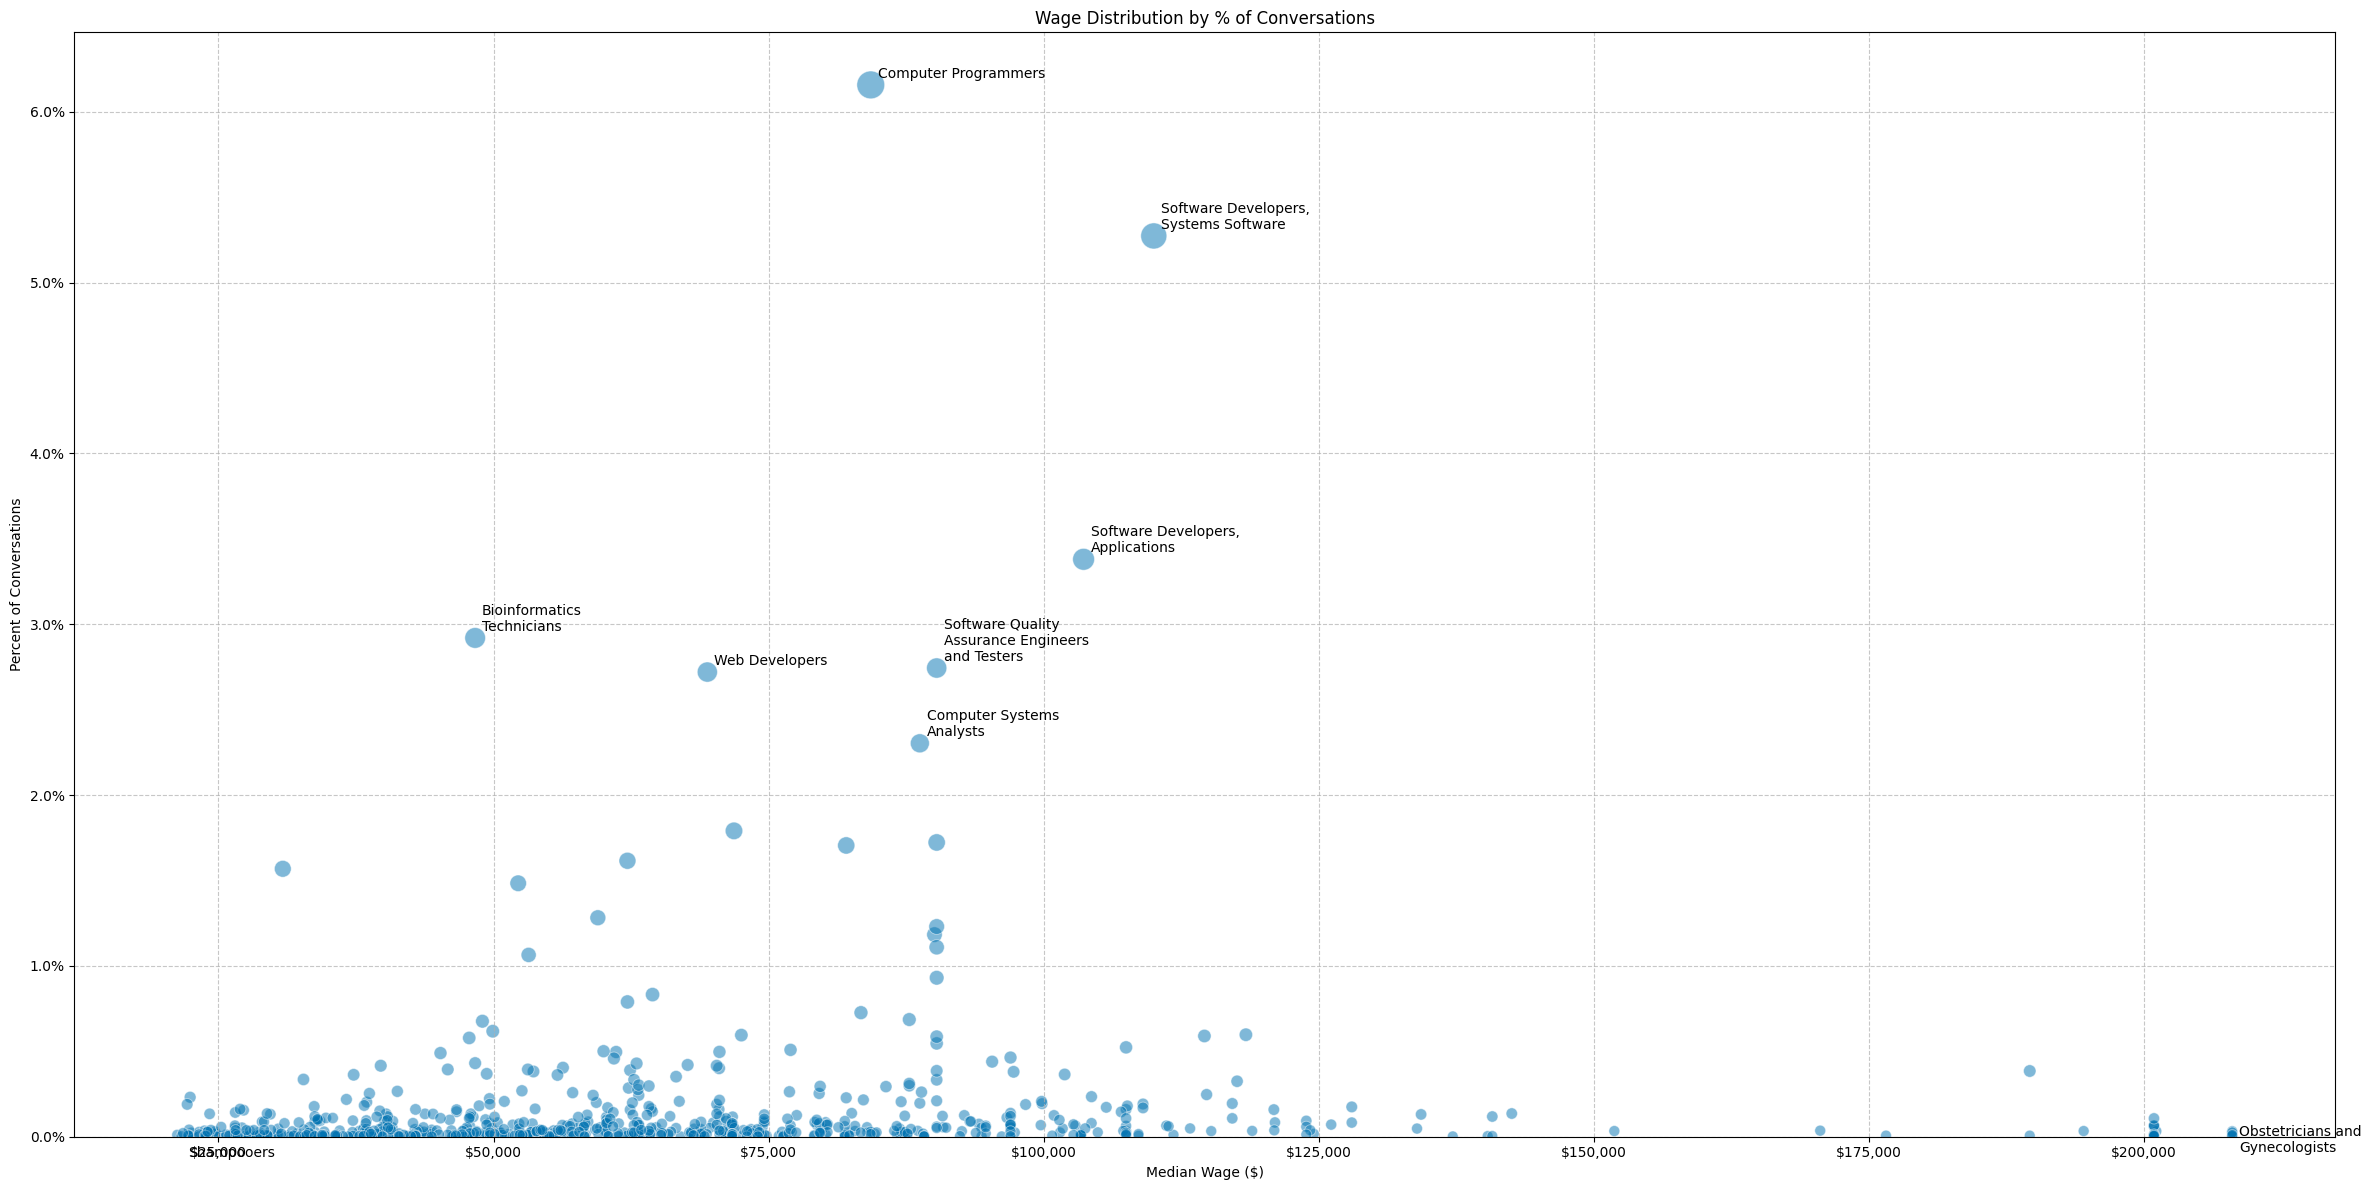

In [18]:
def create_wage_distribution_plot(plot_df):
    # Create figure
    plt.figure(figsize=(24, 12))
    
    # Create scatter plot
    sns.scatterplot(data=plot_df,
                    x='MedianSalary',
                    y='pct_occ_scaled',
                    alpha=0.5,
                    size='pct_occ_scaled',
                    sizes=(60, 400),
                    color=palette[0],
                    legend=False)
    
    # Style the plot
    plt.xlabel('Median Wage ($)')
    plt.ylabel('Percent of Conversations')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))
    
    # Add title
    plt.title('Wage Distribution by % of Conversations'), 
    
    # Annotate points
    # Top points by percentage
    top_n = 7
    for _, row in plot_df.nlargest(top_n, 'pct_occ_scaled').iterrows():
        plt.annotate('\n'.join(wrap(row['Title'], width=20)), 
                    (row['MedianSalary'], row['pct_occ_scaled']),
                    xytext=(5, 5), 
                    textcoords='offset points')
    
    # Extreme salary points
    n_extremes = 2
    # Annotate lowest and highest salaries
    for df_subset in [plot_df.nsmallest(n_extremes, 'MedianSalary'),
                     plot_df.nlargest(n_extremes, 'MedianSalary')]:
        for i, row in enumerate(df_subset.iterrows()):
            if i != 0:  # Skip if already annotated in top_n
                plt.annotate('\n'.join(wrap(row[1]['Title'], width=20)), 
                            (row[1]['MedianSalary'], row[1]['pct_occ_scaled']),
                            xytext=(5, -15),
                            textcoords='offset points')
    
    # Formatting
    plt.ylim(bottom=0)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    plt.tight_layout()
    
    plt.show()
    plt.close()

# Create aggregation dictionary, excluding groupby columns
groupby_cols = ["Title"]
agg_dict = {col: 'first' for col in grouped_with_occupations_and_wage.columns 
            if col not in groupby_cols}
agg_dict['pct_occ_scaled'] = 'sum'


plot_df = (grouped_with_occupations_and_wage
            .groupby(groupby_cols)
            .agg(agg_dict)
            .reset_index()
            .copy())
    
# Filter out null values and very low salaries
plot_df = plot_df[plot_df["MedianSalary"].notnull() & 
                    (plot_df["MedianSalary"] > 100)]
    
# Create and save plot for current group
create_wage_distribution_plot(plot_df)

Loading Anthropic's Economic Index data...
Loading BLS ethnicity data...
Processing occupation data...
Creating simplified visualization...


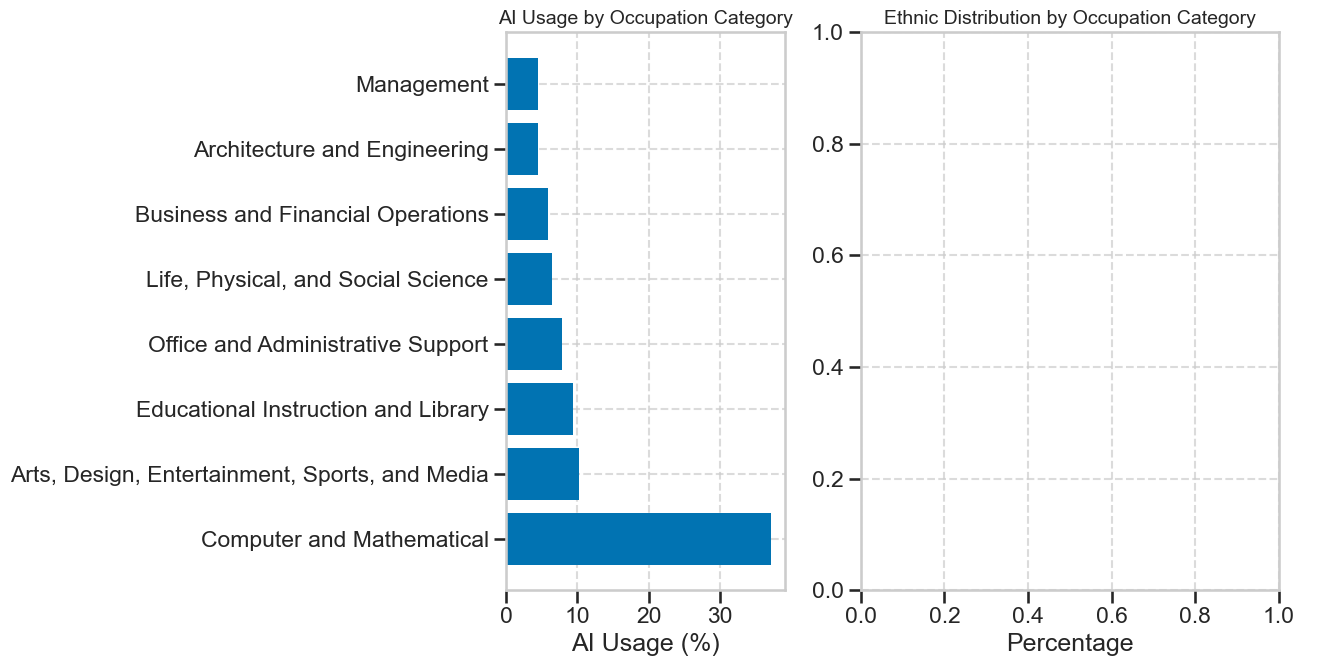

Visualization complete.


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")
plt.rcParams['figure.figsize'] = (12, 8)
palette = sns.color_palette("colorblind")

# 1. Load Anthropic's Economic Index data
print("Loading Anthropic's Economic Index data...")
soc_structure = pd.read_csv("SOC_Structure.csv")
onet_task_mappings = pd.read_csv("onet_task_mappings.csv")
onet_task_statements = pd.read_csv("onet_task_statements.csv")

# 2. Load BLS ethnicity by occupation data
print("Loading BLS ethnicity data...")
occupations_by_ethnicity = pd.read_csv("bls_table8_occupationsbyethnicity_2023.csv")

# 3. Process occupation data
print("Processing occupation data...")
def merge_onet_soc_data():
    onet_df = onet_task_statements.copy()
    onet_df["soc_major_group"] = onet_df["O*NET-SOC Code"].str[:2]
    
    soc_df = soc_structure.copy()
    soc_df = soc_df.dropna(subset=['Major Group'])
    soc_df["soc_major_group"] = soc_df["Major Group"].str[:2]
    
    merged_df = onet_df.merge(
        soc_df[['soc_major_group', 'SOC or O*NET-SOC 2019 Title']],
        on='soc_major_group',
        how='left'
    )
    
    return merged_df

task_occupations_df = merge_onet_soc_data()
task_occupations_df["task_normalized"] = task_occupations_df["Task"].str.lower().str.strip()
task_occupations_df["n_occurrences"] = task_occupations_df.groupby("task_normalized")["Title"].transform("nunique")

grouped_with_occupations = onet_task_mappings.merge(
    task_occupations_df,
    left_on="task_name",
    right_on="task_normalized",
    how="left"
)

grouped_with_occupations["pct_occ_scaled"] = 100 * (grouped_with_occupations["pct"] / grouped_with_occupations["n_occurrences"]) / (grouped_with_occupations["pct"] / grouped_with_occupations["n_occurrences"]).sum()

# 4. Create AI usage by occupation category data
ai_by_occupation_category = grouped_with_occupations.groupby("SOC or O*NET-SOC 2019 Title")["pct_occ_scaled"].sum().reset_index()
ai_by_occupation_category.rename(columns={"pct_occ_scaled": "ai_usage_pct"}, inplace=True)

# 5. Prepare ethnicity data
# Find the relevant columns in the ethnicity data
eth_cols = [col for col in occupations_by_ethnicity.columns if any(eth in col.lower() for eth in ['white', 'black', 'hispanic', 'asian', 'other'])]
occ_cols = [col for col in occupations_by_ethnicity.columns if 'occupation' in col.lower()]

# Create a mapping between occupation titles and SOC categories
soc_mapping = {}
for soc_title in ai_by_occupation_category['SOC or O*NET-SOC 2019 Title'].unique():
    clean_title = soc_title.lower().replace(' occupations', '').strip()
    soc_mapping[clean_title] = soc_title

# Create mapping in the ethnicity data
occupations_by_ethnicity['SOC or O*NET-SOC 2019 Title'] = None
for i, row in occupations_by_ethnicity.iterrows():
    for occ_col in occ_cols:
        if pd.notna(row[occ_col]):
            occ_title = row[occ_col].lower().strip()
            for clean_title, soc_title in soc_mapping.items():
                if clean_title in occ_title or occ_title in clean_title:
                    occupations_by_ethnicity.loc[i, 'SOC or O*NET-SOC 2019 Title'] = soc_title
                    break

# Aggregate ethnicity data by SOC category
ethnicity_by_soc = occupations_by_ethnicity.groupby('SOC or O*NET-SOC 2019 Title')[eth_cols].mean().reset_index()

# Merge AI usage with ethnicity data
merged_data = ai_by_occupation_category.merge(
    ethnicity_by_soc,
    on='SOC or O*NET-SOC 2019 Title',
    how='left'
)

# 6. Create a simpler visualization
print("Creating simplified visualization...")

# Get top 8 occupation categories by AI usage for a cleaner visualization
top_occ_data = merged_data.sort_values('ai_usage_pct', ascending=False).head(8).copy()

# Create clean category labels without "Occupations"
top_occ_data['clean_title'] = top_occ_data['SOC or O*NET-SOC 2019 Title'].str.replace(' Occupations', '')

# Create the figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), gridspec_kw={'width_ratios': [1, 1.5]})

# Plot 1: AI Usage by Occupation (simple bar chart)
ax1.barh(top_occ_data['clean_title'], top_occ_data['ai_usage_pct'], color=palette[0])
ax1.set_xlabel('AI Usage (%)')
ax1.set_title('AI Usage by Occupation Category', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Ethnic Distribution by Occupation (stacked bar chart)
bottom = np.zeros(len(top_occ_data))
colors = ['#1f77b4', '#ff7f0e', '#d62728', '#2ca02c', '#9467bd']  # blue, orange, red, green, purple
eth_labels = [col.replace('_pct', '').title() for col in eth_cols]

for i, col in enumerate(eth_cols):
    ax2.barh(top_occ_data['clean_title'], top_occ_data[col], left=bottom, color=colors[i % len(colors)], label=eth_labels[i])
    bottom += top_occ_data[col]

ax2.set_xlabel('Percentage')
ax2.set_title('Ethnic Distribution by Occupation Category', fontsize=14)
ax2.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
ax2.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.savefig('simplified_ai_ethnicity_by_occupation.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization complete.")